In [1]:
from __future__ import print_function, absolute_import, division

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

In [4]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [5]:
# For loading NIfTI
import nibabel as nib

In [6]:
# Load the FMRI data
img = nib.load('ds114_sub009_t2r1.nii')
data = img.get_data()
data.shape

(64, 64, 30, 173)

In [7]:
# Knock off first four scans
n_dummies = 4
data = data[..., n_dummies:]
n_scans = data.shape[-1]

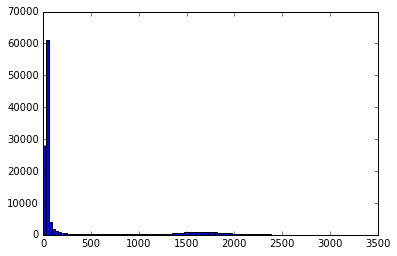

In [8]:
# Use mean image to extract brain
mean_data = data.mean(axis=-1)
_ = plt.hist(np.ravel(mean_data), bins=100)

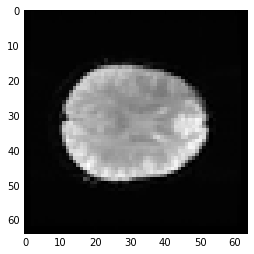

In [9]:
plt.imshow(mean_data[:, :, 15])

In [10]:
# Extract mask with hand-crafted value
mask = mean_data > 900

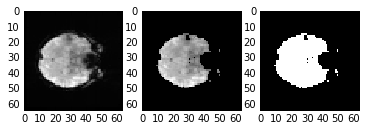

In [11]:
# Show example brain slices
slice_no = 7
fig, axes = plt.subplots(1, 3)
axes[0].imshow(mean_data[:, :, slice_no])
axes[1].imshow((mean_data * mask)[:, :, slice_no])
axes[2].imshow(mask[:, :, slice_no])

In [12]:
# Get in-brain time courses
vox_by_time = data[mask]
vox_by_time.shape

(21353, 169)

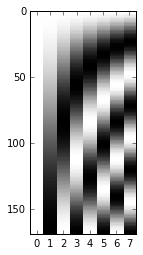

In [13]:
# Make discrete cosine basis set
# See https://en.wikipedia.org/wiki/Discrete_cosine_transform#DCT-II
N = n_scans
n = np.arange(n_scans)
n_plus_half = n + 0.5
dct_basis = np.ones((N, 8))
for k in range(0, 8):
    dct_basis[:, k] = np.cos(np.pi / N * n_plus_half * k)
plt.imshow(dct_basis, aspect=0.1)

In [14]:
# Project out the the DCT basis
time_by_vox = vox_by_time.T
B_dct = spl.pinv(dct_basis).dot(time_by_vox)
filtered_t_v = time_by_vox - dct_basis.dot(B_dct)

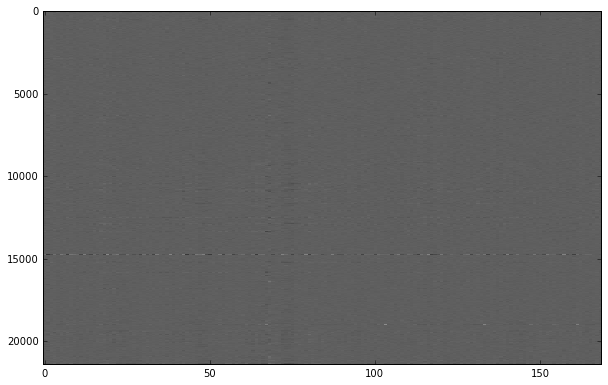

In [15]:
# Do plot similar to Power et al 2013
plt.figure(figsize=(10, 25))
plt.imshow(filtered_t_v.T, aspect=0.005)

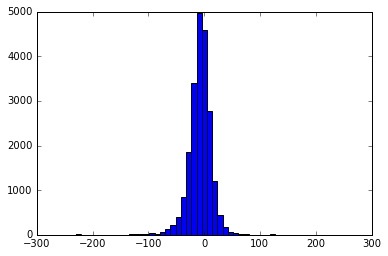

In [16]:
# Plot histogram of all voxel values for first volume
_ = plt.hist(filtered_t_v[0, :], bins=50)

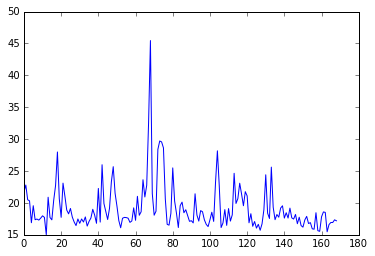

In [17]:
# Are there systematic dips or peaks in variance, shared across voxels?
rms_over_voxels = np.sqrt((filtered_t_v.T ** 2).mean(axis=0))
plt.plot(rms_over_voxels)

Model outlier scans with indicator function columns, modeling effect of each scan.

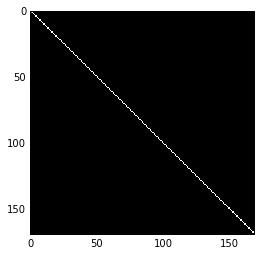

In [18]:
# Make a design matrix with deltas for each scan
X_delta = np.eye(n_scans)
plt.imshow(X_delta)

Now we consider "spin-history" movement effects.  This occur when the subject moves.  The movement causes slices to have be stimulated at an earlier or later time relative to the previous scan.  This difference in stimulation time causes a difference in the sensitivity of the water molecules to MRI (RF) stimulation.   The effect lasts for a few scans, depending on the "T1" or "lattice relaxation" time of the tissue.

From Wikipedia: https://en.wikipedia.org/wiki/Spin%E2%80%93lattice_relaxation

$$
M_z(t) = M_{z,\mathrm{eq}} - \left [ M_{z,\mathrm{eq}} - M_{z}(0) \right ] e^{-t/T_1}
$$

In [19]:
t1_gray_3t = 1.3  # Seconds. Wansapura et al. JMRI 9: 531-538 (1999)
t1_gray_1p5t = 0.920  # Seconds. https://en.wikipedia.org/wiki/Relaxation_(NMR)#T1

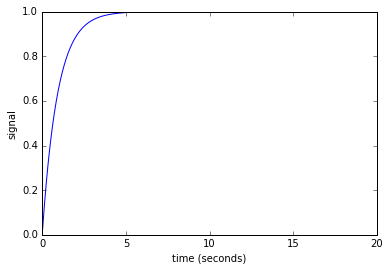

In [20]:
# Plot the T1 effect
Mz_0 = 0
Mz_eq = 1
t = np.linspace(0, 20, 1000)
t1_signal = Mz_eq - (Mz_eq - Mz_0) * np.e ** (-t / t1_gray_1p5t)
plt.plot(t, t1_signal)
plt.xlabel('time (seconds)')
plt.ylabel('signal')

In [21]:
TR = img.header['pixdim'][4]  # Sometimes this is not set correctly
TR

2.5

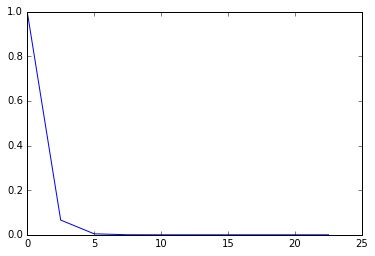

In [22]:
# Make a T1 decay regressor starting at the first scan
t = np.arange(n_scans) * TR
t1_relaxation = np.e ** (-t / t1_gray_1p5t)
plt.plot(t[:10], t1_relaxation[:10])

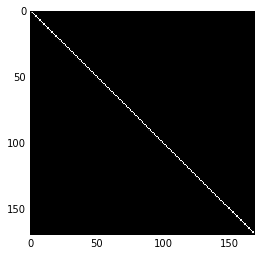

In [23]:
# Make a regressor matrix with this kernel in each column, offset
X_t1 = spl.toeplitz(t1_relaxation, np.zeros(n_scans))
plt.imshow(X_t1)

In [24]:
# Project onto this basis to look for outlier scans
B_t1 = spl.pinv(X_t1).dot(filtered_t_v)

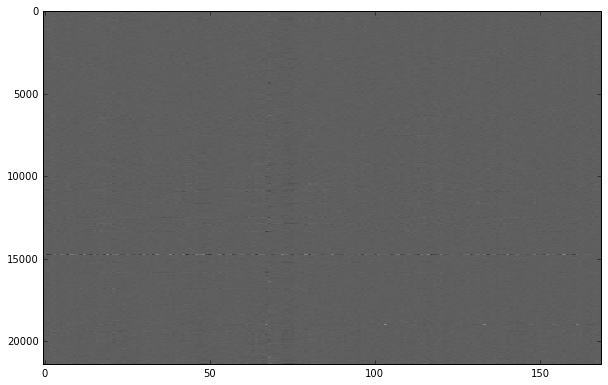

In [25]:
plt.figure(figsize=(10, 25))
plt.imshow(B_t1.T, aspect=0.005)

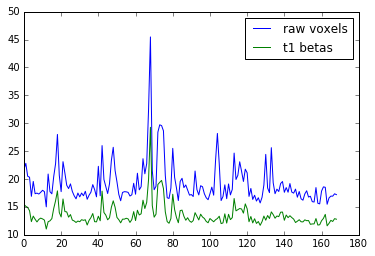

In [26]:
# Are there systematic dips or peaks in these betas across voxels?
rms_over_t1_betas = np.sqrt(B_t1.T ** 2).mean(axis=0)
plt.plot(rms_over_voxels, label='raw voxels')
plt.plot(rms_over_t1_betas, label='t1 betas')
plt.legend()

Lastly consider the situation where the subject moves between scans, and then stays in the new position.  This will cause a step-function change in the signal.  Add these:

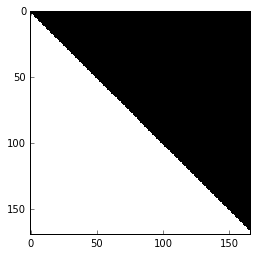

In [27]:
step = np.ones((n_scans))
step[0:2] = 0 # First steps modeled by constant, first delta
X_step = spl.toeplitz(step, np.zeros(n_scans-3)) # last step modeled by last delta
plt.imshow(X_step)

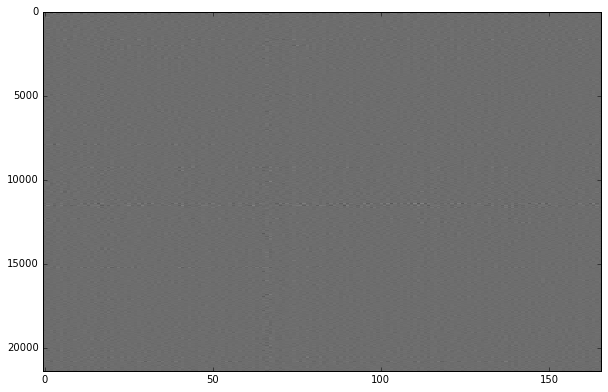

In [28]:
# Project onto this basis to look for outlier scans
B_step = spl.pinv(X_step).dot(filtered_t_v)
plt.figure(figsize=(10, 25))
plt.imshow(B_step.T, aspect=0.005)

Make the experimental part of the design from the block on / off times:

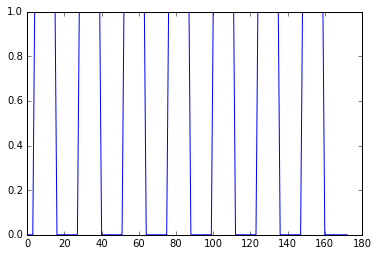

In [35]:
import sys
sys.path.append('consden')
from stimuli import events2neural
neural = events2neural('ds114_sub009_t2r1_cond.txt', TR, img.shape[-1])
plt.plot(neural)

In [36]:
ls

Makefile                    ds114_sub009_t2r1.nii       powers_plots.ipynb          sparse_brain.ipynb
consden/                    ds114_sub009_t2r1_cond.txt  regreg/                     sparse_streamlined.ipynb
design_playing.ipynb        nipype_continues.py         requirements.txt
ds114_sub009_highres.nii    nipype_settings.py          small_func.nii


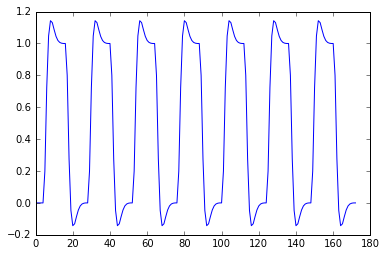

In [37]:
# Convolve with HRF
from spm_funcs import spm_hrf
hrf_times = np.arange(0, 30, TR)
hrf_samples = spm_hrf(hrf_times)
hemo = np.convolve(neural, hrf_samples)[:len(neural)]
plt.plot(hemo)

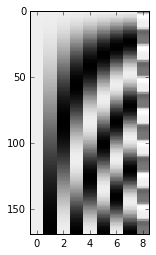

In [38]:
# Knock off dummy scans, compile design
X_e = np.hstack((dct_basis, hemo[n_dummies:, None]))
plt.imshow(X_e, aspect=1/10.)

In [39]:
# Make regreg problem
design = X_e
Y = time_by_vox
X = np.hstack((X_delta, X_t1, X_step))
n_tr, n_vox = Y.shape
n_basis = X.shape[1]
n_tr, n_vox, n_basis

(169, 21353, 504)

In [40]:
import regreg.api as rr

In [41]:
design_pinv = np.linalg.pinv(design)
# Projector onto space of experimental design
P_design = np.dot(design, design_pinv)
# Residual-forming matrix
R_design = np.eye(n_tr) - P_design
# Residuals of data w.r.t design
resid_design = np.dot(R_design, Y)

# X matrix for problem should be residualized w.r.t. design as well 
# -- important
X_ort_design = np.dot(R_design, X)

loss_resid = rr.squared_error(X_ort_design, resid_design)
loss_resid.shape = (n_basis, n_vox)
loss_resid

affine_smooth(quadratic((169,), coef=1, Q=None, Qdiag=False, offset=[[ -1.32363776   3.48115434 -44.57658213 ...,  -8.43813835 -23.79872852
   -6.35979545]
 [  2.85987809   9.39313331 -30.11974225 ..., -30.33784745 -37.79379938
  -26.80326187]
 [  0.9597857   -6.82214392  11.04402434 ...,   7.53732928  12.50782969
    4.65022283]
 ..., 
 [ -5.76125566 -19.90269318  14.97257136 ...,   8.30376192   9.48485253
    6.0527198 ]
 [-20.75115078 -14.98127671 -21.84342779 ...,  15.42850614  17.60386948
   22.22406593]
 [ -0.75091198  26.97947605   8.24754002 ...,  22.48665334   7.66880385
    7.30790964]]), <regreg.affine.linear_transform object at 0x107ade250>, store_grad=True)

In [42]:
penalty = rr.l1_l2(loss_resid.shape, lagrange=1.)
penalty.shape

(504, 21353)

In [88]:
dual_penalty = penalty.conjugate
lam_max = dual_penalty.seminorm(
    loss_resid.smooth_objective(np.zeros(loss_resid.shape), 'grad'),
    lagrange=1)
lam_max

10118.170361456183

In [89]:
penalty.lagrange = 0.9 * lam_max

In [90]:
# Residual problem after orthogonalizing w.r.t experimental design
problem_resid = rr.simple_problem(loss_resid, penalty)
problem_resid

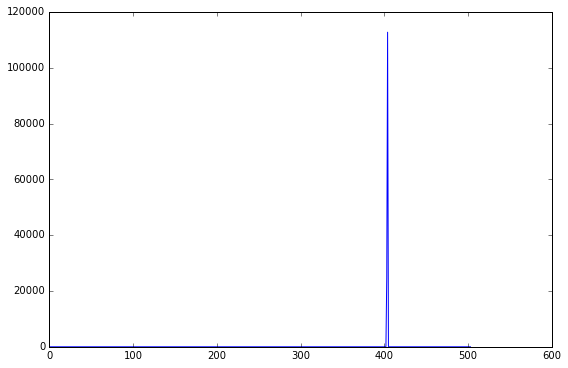

In [91]:
soln_resid = problem_resid.solve(min_its=200, tol=1.e-12)
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
ax.plot((soln_resid**2).sum(1))

In [92]:
np.sum((soln_resid**2).sum(1) != 0)

2

In [93]:
# Reconstructing estimates for experimental design
coefs_resid = np.dot(design_pinv, Y - np.dot(X, soln_resid))
coefs_resid.shape

(9, 21353)

In [94]:
# Coefficients without sparse part
coefs = design_pinv.dot(Y)
coefs.shape

(9, 21353)

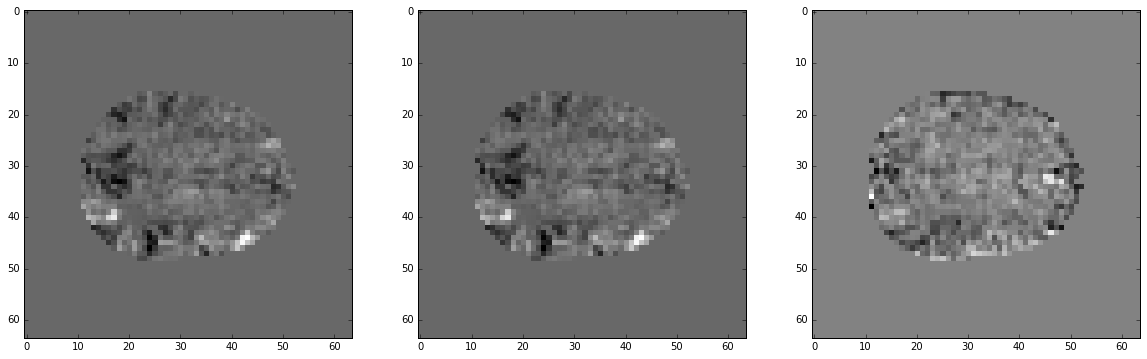

In [95]:
task_resid = np.zeros(mean_data.shape)
task = np.zeros(mean_data.shape)
task_resid[mask] = coefs_resid[-1, :]
task[mask] = coefs[-1, :]
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(task_resid[:, :, 14])
axes[1].imshow(task[:, :, 14])
axes[2].imshow((task - task_resid)[:, :, 14])

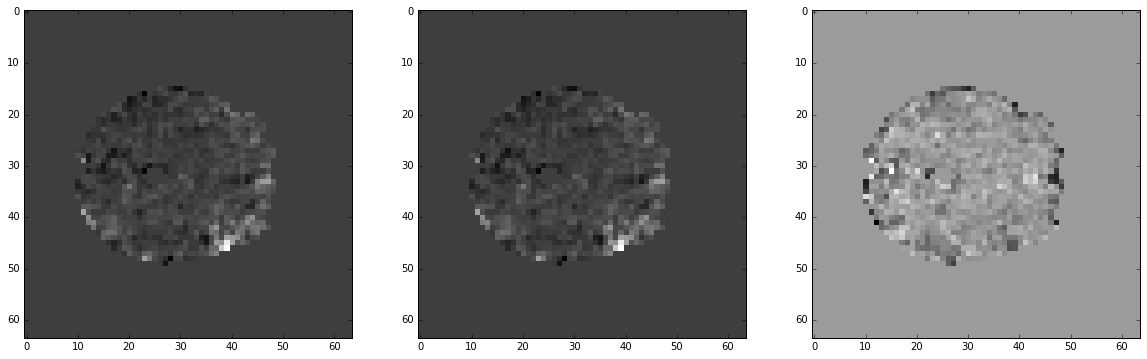

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(task_resid[:, :, 10])
axes[1].imshow(task[:, :, 10])
axes[2].imshow((task - task_resid)[:, :, 10])

In [43]:
penalty = rr.l1_l2((10, 20), lagrange=1.)

In [50]:
penalty.solve?